In [14]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('E:/Projects/Learn ML/loan-default-predictor/data/final_data.csv')

In [6]:
df = df.sort_values(by='issue_d_date').reset_index(drop=True)

In [7]:
X = df.drop(columns=['loan_status', 'issue_d_date'])
y = df['loan_status']

In [10]:
X.head()

,dti,open_acc,total_acc,mort_acc,fico_range,term_num,int_rate_num,sub_grade_map,emp_length_num,revol_util_num,...,verification_status_Verified,home_ownership_new_MORTGAGE,home_ownership_new_OTHER,home_ownership_new_OWN,home_ownership_new_RENT,mort_acc_utilization,int_rate_per_fico,flag_high_int_rate,flag_high_sub_grade,flag_low_fico
0,14.29,7.0,8.0,0.0,662.0,36,13.75,22,0.5,51.5,...,False,False,False,True,False,0.000,0.020770,0,0,0
1,2.55,4.0,7.0,0.0,772.0,36,7.43,2,6.0,14.0,...,False,False,False,False,True,0.000,0.009624,0,0,0
2,0.00,5.0,8.0,1.0,677.0,36,10.28,11,2.0,0.0,...,False,True,False,False,False,0.125,0.015185,0,0,0
3,14.54,10.0,13.0,0.0,752.0,36,8.70,6,0.5,7.8,...,False,True,False,False,False,0.000,0.011569,0,0,0
4,10.70,4.0,4.0,0.0,712.0,36,10.28,11,0.5,54.4,...,False,False,False,False,True,0.000,0.014438,0,0,0


In [11]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
lgbm = LGBMClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}
lgbm_gs = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
lgbm_gs.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 57876, number of negative: 238979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 296855, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194964 -> initscore=-1.418073
[LightGBM] [Info] Start training from score -1.418073


,estimator,LGBMClassifie...ndom_state=42)
,param_grid,"{'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200], 'num_leaves': [31, 50]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [25]:
y_pred = lgbm_gs.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, lgbm_gs.predict_proba(X_test)[:, 1]))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     59745
           1       0.56      0.06      0.11     14469

    accuracy                           0.81     74214
   macro avg       0.69      0.52      0.50     74214
weighted avg       0.76      0.81      0.74     74214

ROC AUC Score: 0.7121820389453111
Accuracy Score: 0.8075026275365834


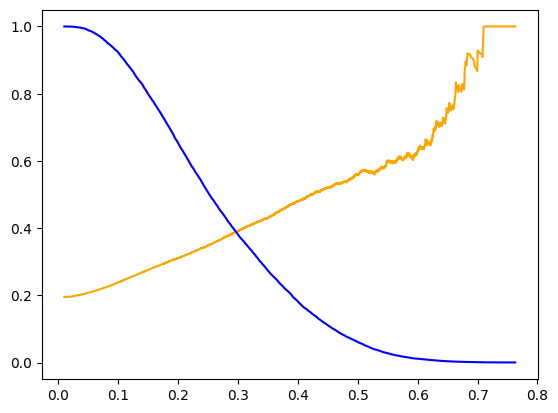

In [29]:
from sklearn.metrics import precision_recall_curve
y_pred_proba = lgbm_gs.predict_proba(X_test)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_test, y_pred_proba)
import matplotlib.pyplot as plt
plt.plot(thresholds, prec[:-1], label='Precision', color='orange')
plt.plot(thresholds, rec[:-1], label='Recall', color='blue')

In [47]:
beta=1.0
f1_scores = 2*prec*rec*(1+beta*beta)/((beta*beta)*prec+rec+1e-8)
best_thre = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_thre)
y_pred_adjusted = (y_pred_proba >= best_thre).astype(int)
print(classification_report(y_test, y_pred_adjusted))

Best Threshold: 0.19191262754270702
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     59745
           1       0.31      0.68      0.42     14469

    accuracy                           0.64     74214
   macro avg       0.60      0.65      0.58     74214
weighted avg       0.78      0.64      0.67     74214



In [58]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as p
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve

tscv = TimeSeriesSplit(n_splits=10)
fold = 1
metrics_log = []

betas = [0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25]

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    neg_count = (y_train_fold == 0).sum()
    pos_count = (y_train_fold == 1).sum()
    fold_ratio = (neg_count / pos_count) if pos_count > 0 else 1.0

    model = LGBMClassifier(
        class_weight={0: 1, 1: fold_ratio},
        random_state=42,
        verbosity=-1,
    )

    model.fit(X_train_fold, y_train_fold)

    prob = model.predict_proba(X_test_fold)[:, 1]

    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test_fold, prob)

    precision_t = precision_curve[:-1]
    recall_t = recall_curve[:-1]

    test_end_date = df.iloc[test_index[-1]]["issue_d_date"]
    print(f"Fold {fold}: Testing on data ending {test_end_date}")

    for beta in betas:
        beta2 = beta * beta
        fbeta_scores = (1 + beta2) * precision_t * recall_t / (beta2 * precision_t + recall_t + 1e-8)

        best_idx = int(np.argmax(fbeta_scores))
        best_thre = float(thresholds[best_idx])

        preds = (prob >= best_thre).astype(int)

        acc = accuracy_score(y_test_fold, preds)
        rec = recall_score(y_test_fold, preds)
        prec = precision_score(y_test_fold, preds)

        metrics_log.append([fold, beta, best_thre, acc, rec, prec])
        print(f"    beta={beta:.2f} | thr={best_thre:.4f} | Recall: {rec:.2f} | Precision: {prec:.2f} | Accuracy: {acc:.2f}")

    fold += 1

metrics_df = pd.DataFrame(metrics_log, columns=["Fold", "Beta", "BestThreshold", "Accuracy", "Recall", "Precision"])
print("\n--- Average Performance Across All Time Periods ---")
print(metrics_df.groupby("Beta")[["Accuracy", "Recall", "Precision"]].mean().sort_index())

Fold 1: Testing on data ending 2014-07-01
    beta=0.95 | thr=0.5328 | Recall: 0.56 | Precision: 0.27 | Accuracy: 0.68
    beta=1.00 | thr=0.5052 | Recall: 0.62 | Precision: 0.25 | Accuracy: 0.64
    beta=1.05 | thr=0.5052 | Recall: 0.62 | Precision: 0.25 | Accuracy: 0.64
    beta=1.10 | thr=0.5052 | Recall: 0.62 | Precision: 0.25 | Accuracy: 0.64
    beta=1.15 | thr=0.5047 | Recall: 0.62 | Precision: 0.25 | Accuracy: 0.64
    beta=1.20 | thr=0.4672 | Recall: 0.70 | Precision: 0.24 | Accuracy: 0.59
    beta=1.25 | thr=0.4668 | Recall: 0.70 | Precision: 0.24 | Accuracy: 0.59
Fold 2: Testing on data ending 2015-02-01
    beta=0.95 | thr=0.5388 | Recall: 0.59 | Precision: 0.30 | Accuracy: 0.68
    beta=1.00 | thr=0.5388 | Recall: 0.59 | Precision: 0.30 | Accuracy: 0.68
    beta=1.05 | thr=0.5326 | Recall: 0.60 | Precision: 0.30 | Accuracy: 0.67
    beta=1.10 | thr=0.5066 | Recall: 0.66 | Precision: 0.29 | Accuracy: 0.64
    beta=1.15 | thr=0.5066 | Recall: 0.66 | Precision: 0.29 | Accurac

### got almost similar results as xgboost with lightgbm, recall: 67.25%, precision: 31.4% at beta 1.10

In [59]:
## save the model
import joblib
joblib.dump(lgbm_gs, 'E:/Projects/Learn ML/loan-default-predictor/data/lightGBM_loan_default_model.pkl')

['E:/Projects/Learn ML/loan-default-predictor/data/lightGBM_loan_default_model.pkl']